# Model Comparison — Neural Networks + Boosting

This notebook compares **all available model prediction files** on the **same labeled holdout set** (matched by `UNIQUEID` and `y_true`).

It supports:
- Neural networks:
  - `results/nn_baseline_test_preds.csv`
  - `results/nn_improved_test_preds.csv`
- Boosting (from `03_boosting.ipynb`):
  - `results/boosting_best_test_preds.csv` (recommended aggregate/best)
  - (optional) per-model files if you exported them:
    - `results/boosting_xgb_test_preds.csv`
    - `results/boosting_lgbm_test_preds.csv`
    - `results/boosting_cat_test_preds.csv`

All files must contain **the same rows** (same `UNIQUEID`s) for an apples-to-apples comparison.

**Expected columns in each prediction file**
- `UNIQUEID`
- `y_true` (0/1)
- `y_prob` (predicted probability of default)

---

## What this notebook does
1. Loads all prediction files that exist (you can toggle models with `ENABLED_MODELS`).
2. Inner-joins them on (`UNIQUEID`, `y_true`) to ensure a strict same-row comparison.
3. Computes metrics at a shared threshold (default `t=0.50`).
4. Plots ROC curves for all included models.


In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    log_loss,
    brier_score_loss,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    balanced_accuracy_score,
    confusion_matrix,
    roc_curve,
    precision_recall_curve,
)


import matplotlib.pyplot as plt

# Paths
RESULTS_DIR = Path('..') / 'results'

PRED_FILES = {
    # Neural nets
    "NN - Baseline MLP": RESULTS_DIR / "nn_baseline_test_preds.csv",
    "NN - Improved MLP": RESULTS_DIR / "nn_improved_test_preds.csv",

    # Boosting (best/aggregate)
    "Boosting - Best": RESULTS_DIR / "boosting_best_test_preds.csv",
    "Boosting - XGBoost": RESULTS_DIR / "boosting_xgb_test_preds.csv",
    "Boosting - LightGBM": RESULTS_DIR / "boosting_lgbm_test_preds.csv",
    "Boosting - CatBoost": RESULTS_DIR / "boosting_cat_test_preds.csv",
}

ENABLED_MODELS = {
    "NN - Baseline MLP": True,
    "NN - Improved MLP": True,
    "Boosting - Best": True,
    "Boosting - XGBoost": True,
    "Boosting - LightGBM": True,
    "Boosting - CatBoost": True,
}

ID_COL = "UNIQUEID"
REQUIRED_COLS = {ID_COL, "y_true", "y_prob"}


In [2]:
def _load_preds(label: str, path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    missing = REQUIRED_COLS - set(df.columns)
    assert not missing, f"{label} file missing columns: {missing} (path={path})"

    # Keep only what we need; enforce types lightly
    out = df[[ID_COL, "y_true", "y_prob"]].copy()
    out["y_true"] = out["y_true"].astype(int)
    out["y_prob"] = out["y_prob"].astype(float)
    return out


loaded = {}
skipped = []

for label, path in PRED_FILES.items():
    if not ENABLED_MODELS.get(label, False):
        skipped.append((label, "disabled"))
        continue
    if not path.exists():
        skipped.append((label, f"missing file: {path}"))
        continue

    loaded[label] = _load_preds(label, path)

print("Loaded models:", list(loaded.keys()))
if skipped:
    print("\nSkipped:")
    for label, reason in skipped:
        print(f" - {label}: {reason}")

assert len(loaded) >= 2, "Need at least 2 prediction files to compare."


Loaded models: ['NN - Baseline MLP', 'NN - Improved MLP', 'Boosting - XGBoost', 'Boosting - LightGBM', 'Boosting - CatBoost']

Skipped:
 - Boosting - Best: missing file: ..\results\boosting_best_test_preds.csv


In [3]:
items = list(loaded.items())

merged = items[0][1].rename(columns={"y_prob": f"y_prob__{items[0][0]}"})

for label, df in items[1:]:
    merged = merged.merge(
        df.rename(columns={"y_prob": f"y_prob__{label}"}),
        on=[ID_COL, "y_true"],
        how="inner",
    )

print("Row counts per file:")
for label, df in loaded.items():
    print(f" - {label}: {len(df):,}")

print("\nMatched rows (intersection across all loaded):", f"{len(merged):,}")

display(merged.head())


Row counts per file:
 - NN - Baseline MLP: 34,974
 - NN - Improved MLP: 34,974
 - Boosting - XGBoost: 34,974
 - Boosting - LightGBM: 34,974
 - Boosting - CatBoost: 34,974

Matched rows (intersection across all loaded): 34,974


,UNIQUEID,y_true,y_prob__NN - Baseline MLP,y_prob__NN - Improved MLP,y_prob__Boosting - XGBoost,y_prob__Boosting - LightGBM,y_prob__Boosting - CatBoost
0,490213,0,0.687483,0.673230,0.312877,0.211317,0.302292
1,492995,1,0.841740,0.827259,0.516769,0.554029,0.602079
2,586411,0,0.558664,0.559846,0.236244,0.225780,0.249987
3,519075,0,0.468006,0.486597,0.168035,0.171749,0.189802
4,525983,0,0.290159,0.284628,0.103246,0.102936,0.109797


In [4]:
def metrics_at_threshold(y: np.ndarray, p: np.ndarray, t: float = 0.50) -> dict:
    yhat = (p >= t).astype(int)

    tn, fp, fn, tp = confusion_matrix(y, yhat).ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    eps = 1e-15  # avoid log_loss issues with exact 0/1 probs
    p_clip = np.clip(p, eps, 1 - eps)

    return {
        "auc_roc": float(roc_auc_score(y, p)),
        "auc_pr": float(average_precision_score(y, p)),
        "log_loss": float(log_loss(y, p_clip)),
        "brier": float(brier_score_loss(y, p)),
        "accuracy": float(accuracy_score(y, yhat)),
        "balanced_acc": float(balanced_accuracy_score(y, yhat)),
        f"precision@{t:.2f}": float(precision_score(y, yhat, zero_division=0)),
        f"recall@{t:.2f}": float(recall_score(y, yhat, zero_division=0)),
        f"specificity@{t:.2f}": float(specificity),
        f"f1@{t:.2f}": float(f1_score(y, yhat, zero_division=0)),
        "tp": int(tp), "fp": int(fp), "tn": int(tn), "fn": int(fn),
    }

t = 0.50

y_true = merged["y_true"].astype(int).values

rows = {}
for label in loaded.keys():
    p = merged[f"y_prob__{label}"].values.astype(float)
    rows[label] = metrics_at_threshold(y_true, p, t=t)

summary = pd.DataFrame(rows).T.sort_values("auc_roc", ascending=False)
summary


,auc_roc,auc_pr,log_loss,brier,accuracy,balanced_acc,precision@0.50,recall@0.50,specificity@0.50,f1@0.50,tp,fp,tn,fn
Boosting - CatBoost,0.666400,0.344419,0.493343,0.159949,0.783925,0.507541,0.568627,0.019099,0.995983,0.036957,145.0,110.0,27272.0,7447.0
Boosting - XGBoost,0.666278,0.343337,0.493397,0.159987,0.783525,0.508142,0.534426,0.021470,0.994814,0.041281,163.0,142.0,27240.0,7429.0
Boosting - LightGBM,0.665569,0.342976,0.493600,0.160064,0.783182,0.506828,0.516605,0.018440,0.995216,0.035610,140.0,131.0,27251.0,7452.0
NN - Baseline MLP,0.650593,0.325208,0.654173,0.232047,0.574055,0.608315,0.290820,0.668862,0.547769,0.405381,5078.0,12383.0,14999.0,2514.0
NN - Improved MLP,0.648562,0.323609,0.650185,0.229896,0.592269,0.604811,0.294045,0.626976,0.582646,0.400336,4760.0,11428.0,15954.0,2832.0


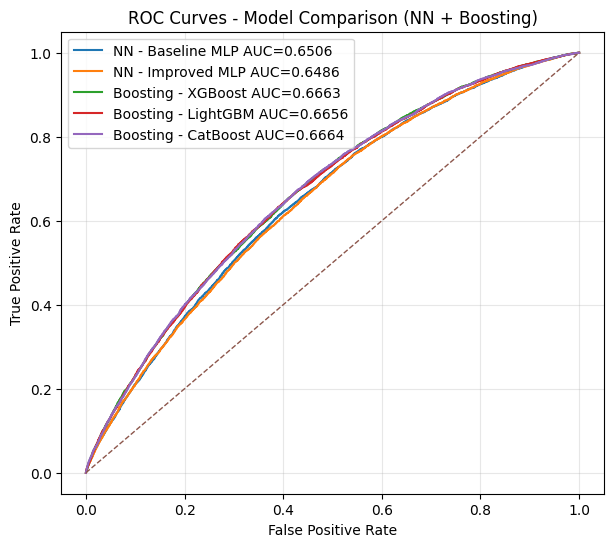

In [5]:
plt.figure(figsize=(7, 6))

for label in loaded.keys():
    p = merged[f"y_prob__{label}"].values.astype(float)
    fpr, tpr, _ = roc_curve(y_true, p)
    auc = roc_auc_score(y_true, p)
    plt.plot(fpr, tpr, label=f"{label} AUC={auc:.4f}")

plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Model Comparison (NN + Boosting)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


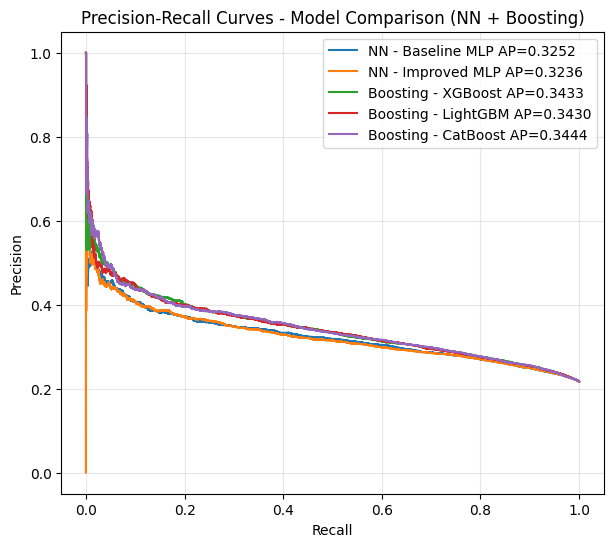

In [6]:
plt.figure(figsize=(7, 6))

for label in loaded.keys():
    p = merged[f"y_prob__{label}"].values.astype(float)
    prec, rec, _ = precision_recall_curve(y_true, p)
    ap = average_precision_score(y_true, p)
    plt.plot(rec, prec, label=f"{label} AP={ap:.4f}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves - Model Comparison (NN + Boosting)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [7]:
summary = pd.DataFrame(rows).T.sort_values(["auc_pr", "auc_roc"], ascending=False)
summary

,auc_roc,auc_pr,log_loss,brier,accuracy,balanced_acc,precision@0.50,recall@0.50,specificity@0.50,f1@0.50,tp,fp,tn,fn
Boosting - CatBoost,0.666400,0.344419,0.493343,0.159949,0.783925,0.507541,0.568627,0.019099,0.995983,0.036957,145.0,110.0,27272.0,7447.0
Boosting - XGBoost,0.666278,0.343337,0.493397,0.159987,0.783525,0.508142,0.534426,0.021470,0.994814,0.041281,163.0,142.0,27240.0,7429.0
Boosting - LightGBM,0.665569,0.342976,0.493600,0.160064,0.783182,0.506828,0.516605,0.018440,0.995216,0.035610,140.0,131.0,27251.0,7452.0
NN - Baseline MLP,0.650593,0.325208,0.654173,0.232047,0.574055,0.608315,0.290820,0.668862,0.547769,0.405381,5078.0,12383.0,14999.0,2514.0
NN - Improved MLP,0.648562,0.323609,0.650185,0.229896,0.592269,0.604811,0.294045,0.626976,0.582646,0.400336,4760.0,11428.0,15954.0,2832.0


## What we learned: Neural Networks vs. Boosting (Credit Default)

This project highlights a common pattern in tabular credit-risk modeling: **gradient-boosted trees typically outperform standard MLPs on ranking/discrimination**, while **MLPs can appear better at a fixed threshold** depending on how their predicted probabilities are distributed.

---

### 1) Boosting models rank risk better (best AUCs)

Across **CatBoost**, **XGBoost**, and **LightGBM**, the boosting models achieve the strongest ranking performance:

- **ROC-AUC:** ~**0.666**
- **PR-AUC:** ~**0.343–0.344**

This indicates they are better at ordering borrowers from low to high risk—often the most important capability in credit decisioning.

The neural networks are slightly weaker rankers:

- **Baseline MLP:** ROC-AUC **0.6506**, PR-AUC **0.3252**
- **Improved MLP:** ROC-AUC **0.6486**, PR-AUC **0.3236**

So while the MLPs learn useful signal, the boosting models extract more predictive structure from this dataset.

---

### 2) The “best model” depends on the operating point (threshold matters)

At the default decision threshold **t = 0.50**, boosting models show **very high precision** but **extremely low recall (~2%)**. This is not because they cannot identify defaulters—rather, their predicted probabilities are rarely above 0.5, so they almost never predict “default” at that cutoff.

The MLPs behave very differently at the same threshold:

- **Baseline MLP:** recall@0.50 **0.6689**, precision@0.50 **0.2908**
- **Improved MLP:** recall@0.50 **0.6270**, precision@0.50 **0.2940**

**Key takeaway:** in imbalanced credit settings, **threshold selection is part of the model**. Comparing models only at **t = 0.50** can be misleading unless 0.50 is a business-meaningful operating point (it usually is not).

---

### 3) Calibration and probability quality matter in credit

Boosting models also produce substantially better probability-quality metrics:

- **Log loss:** ~**0.493** (boosting) vs ~**0.65** (MLPs)
- **Brier score:** ~**0.160** (boosting) vs ~**0.23** (MLPs)

This suggests boosting provides **more reliable probability estimates** in the current setup, which matters if outputs are interpreted as PD-like values or used in downstream expected loss / pricing calculations.

---

### 4) Practical pros/cons observed

#### Boosting (CatBoost / XGBoost / LightGBM)
**Pros**
- Best discrimination on tabular data (strong ROC-AUC / PR-AUC)
- Strong performance with limited feature engineering
- Good interpretability tooling (feature importance, SHAP)

**Cons**
- Needs explicit handling of class imbalance and threshold choice for business objectives
- May benefit from probability calibration depending on the use case

#### Neural Networks (Baseline / Improved MLP)
**Pros**
- Flexible and extensible (custom losses such as cost-sensitive or focal loss)
- Can achieve high recall at some thresholds

**Cons**
- Underperformed boosting here on ranking and calibration
- Sensitive to preprocessing and categorical encoding
- Vanilla MLPs are rarely the best choice for classic structured credit datasets without more specialized tabular DL methods

---

## Final recommendation

For this dataset and pipeline, a **boosting model** (CatBoost / XGBoost / LightGBM) is the best default choice because it delivers the best **risk ranking** and **probability quality**. However, it should **not** be deployed with a fixed **t = 0.50**. The decision threshold should be selected on a validation set based on the business objective (e.g., minimum recall, minimum precision, profit / expected loss).

---

## Next steps to improve results

- **Tune thresholds per model** (especially boosting) on validation data:
    - maximize F1, or
    - satisfy precision/recall constraints
- **Calibrate probabilities** (Platt scaling or isotonic regression), then re-evaluate:
    - log loss, Brier score, and threshold-based metrics
- **Stronger boosting tuning for imbalance**:
    - `scale_pos_weight`, class weights, depth/leaf constraints
- **For neural networks**:
    - try categorical embeddings (instead of full one-hot)
    - test tabular-focused architectures
    - apply stronger regularization and smaller/better-tuned networks
- Add credit-focused evaluation beyond AUC:
    - KS / lift
    - top-*k* capture rate
    - cost-based metrics aligned with lending decisions